- [티스토리 참고링크](https://littlefoxdiary.tistory.com/86)
- [텐서플로우 전이학습 및 미세조정](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko)

# 사전 학습된 ConvNet을 이용한 전이 학습

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 데이터 전처리

### 데이터 다운로드

In [3]:
# 클라우드에 있는 파일 URL
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# 파일을 다운로드하고 압축해제
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# 파일을 읽어올 주소
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# 파일이 위치한 곳의 트레인셋과 벨리데이션셋 주소
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# 배치사이즈 32, 이미지 사이즈 160x160
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# 트레인셋을 읽어옴, 파일을 랜덤하게 섞고, 이미지 사이즈와 배치사이즈에 맞게 조정
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
# 벨리데이션셋을 읽어옴, 파일을 랜덤하게 섞고, 이미지 사이즈와 배치사이즈에 맞게 조정
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


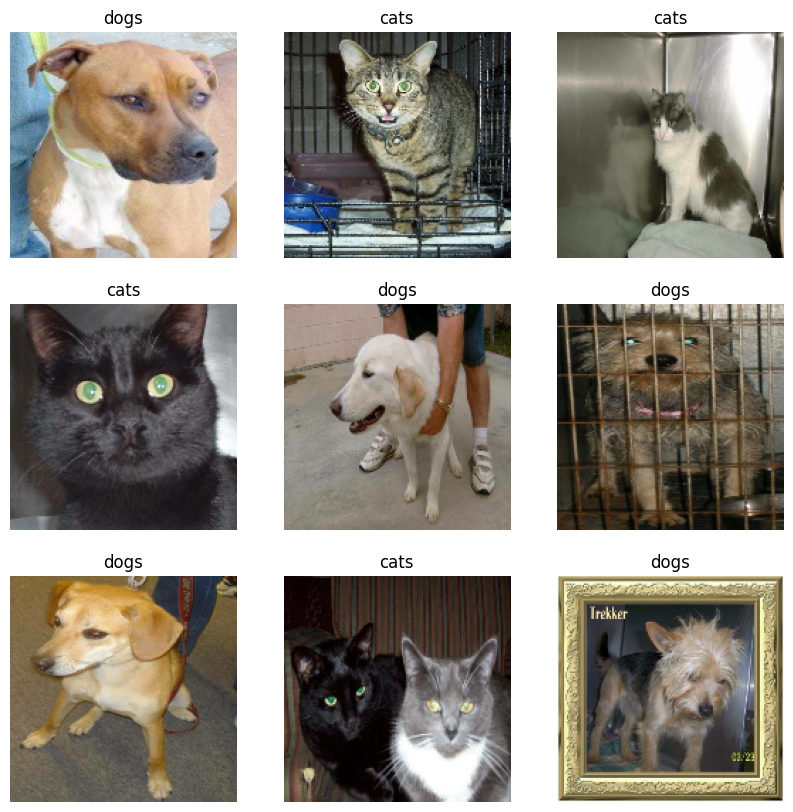

In [5]:
# 레이블 이름
class_names = train_dataset.class_names

# 파일을 잘 불러왔는지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# 테스트셋이 없으니 벨리데이션셋에서 20프로를 추출
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
# 벨리데이션셋 배치수와 테스트셋 배치 수
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
# 입력 파이프라인
AUTOTUNE = tf.data.AUTOTUNE

# 데이터를 멀티스레드로 불러오기
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강 사용

In [9]:
# 데이터 증강을 이용해서 데이터셋의 규모를 키우고, 오버피팅 방지
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), # 수평으로 랜덤하게 뒤집기
  tf.keras.layers.RandomRotation(0.2), # 랜덤하게 회전시킨다
])

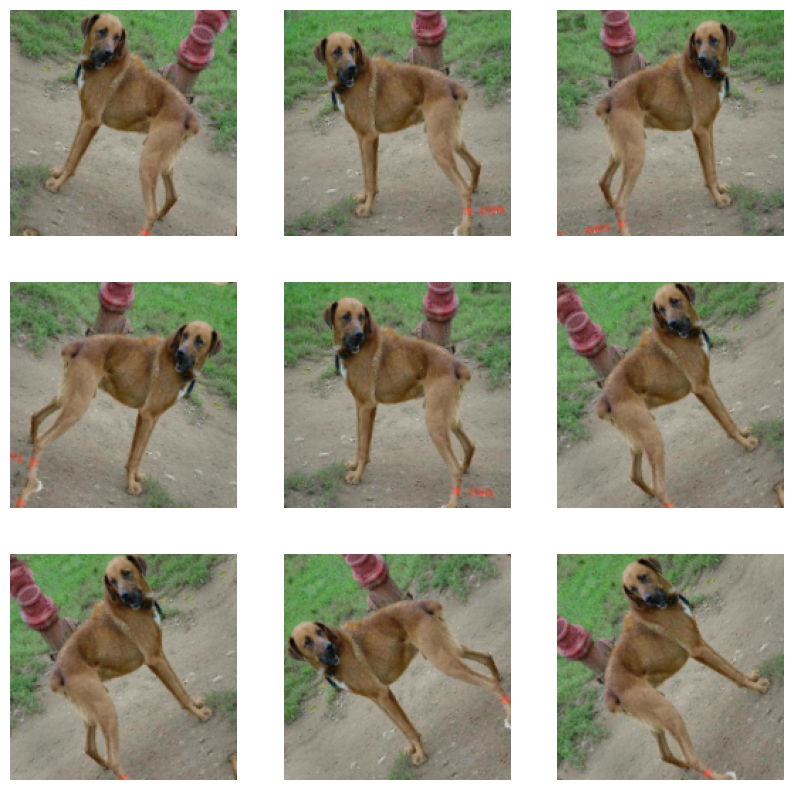

In [10]:
# 2000/32개 중 첫 데이터셋 묶음을 불러와서 데이터 증강이 잘되는지 확인
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0] # 첫 사진
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) # 증강 적용
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
# 기본 모델 MobileNetV2은 -1~1사이의 픽셀 값만 인풋으로 받는다.
# 현재 이미지의 값은 0~255니까 preprocess_input으로 -1~1로 조정
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

[모바일넷v2 참고링크](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)

In [12]:
# MobileNet V2로 기본 모델 생성. 
# include_top = False로 디폴트 인풋 레이어를 사용하지 않음.
# imagenet으로 훈련된 가중치를 이용.

IMG_SHAPE = IMG_SIZE + (3,) # 160,160,3
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
# 160,160,3을 인풋으로 받고 5,5,1280으로 아웃풋
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


[전이학습 가이드 링크](https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko)

In [14]:
# 훈련중에 주어진 레이어의 가중치가 업데이트 되는 것을 방지하기
# layer.trainable = False를 설정하면 BatchNormalization 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.
base_model.trainable = False

In [15]:
# 베이스 모델 확인하
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
# GlobalAveragePooling2D로 베이스 모델의 아우풋을 피처벡터로 만드는 레이어 적용

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
# 1280차원 벡터를 다운스트림 분류 문제로 매핑하는 덴스레이어를 쌓는다. 양수: 1, 음수: 0

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
# 데이터 증강, 리스케일링, 모바일넷v2, 분류레이어 적용

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
# 손실함수로 이중분류니까 binarycrossentropy, 옵티마이저로 adam

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [21]:
# 에포크 10으로 평가해보기
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 147ms/step - loss: 0.9303 - accuracy: 0.4889


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.49


In [23]:
# 에포크 10으로 훈련
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 15s 216ms/step - loss: 0.7876 - accuracy: 0.5245 - val_loss: 0.5921 - val_accuracy: 0.6213
Epoch 2/10
63/63 [==============================] - 14s 220ms/step - loss: 0.5690 - accuracy: 0.6690 - val_loss: 0.4292 - val_accuracy: 0.7525
Epoch 3/10
63/63 [==============================] - 14s 220ms/step - loss: 0.4554 - accuracy: 0.7635 - val_loss: 0.3249 - val_accuracy: 0.8317
Epoch 4/10
63/63 [==============================] - 16s 253ms/step - loss: 0.3770 - accuracy: 0.8135 - val_loss: 0.2630 - val_accuracy: 0.8837
Epoch 5/10
63/63 [==============================] - 16s 256ms/step - loss: 0.3348 - accuracy: 0.8370 - val_loss: 0.2283 - val_accuracy: 0.8998
Epoch 6/10
63/63 [==============================] - 16s 255ms/step - loss: 0.3106 - accuracy: 0.8535 - val_loss: 0.1975 - val_accuracy: 0.9183
Epoch 7/10
63/63 [==============================] - 15s 243ms/step - loss: 0.2690 - accuracy: 0.8845 - val_loss: 0.1806 - val_accuracy: 0.9245
Epoch 8/10

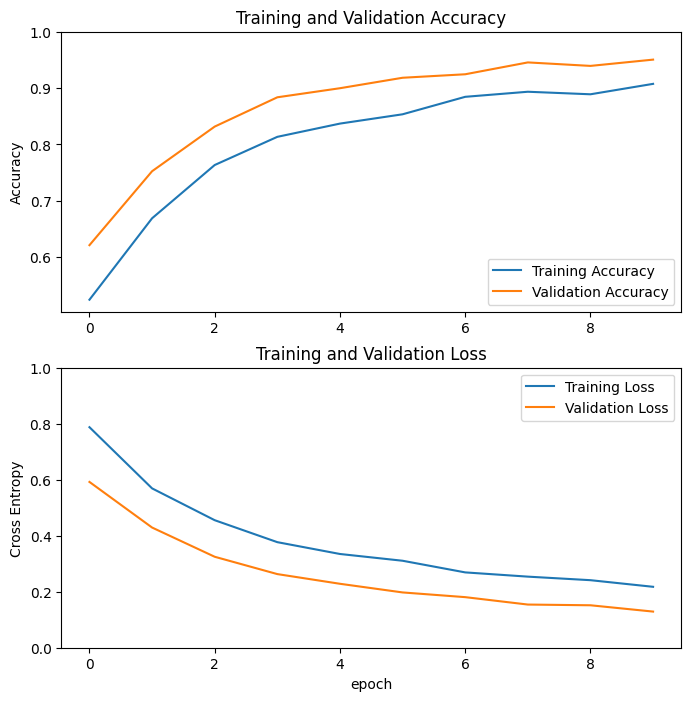

In [24]:
# 그래프가 갖는 의미를 솔직히 모르겠음

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### 미세조정
Note: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 합니다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 됩니다.

In [25]:
# 사전 훈련된 네트워크의 가중치는 업데이트가 되지 않았다. 
# 이제 업데이트하면서 훈련할거다
# 베이스 모델 훈련 고정 해제
base_model.trainable = True

In [26]:
# 베이스 모델의 레이어 수
print("Number of layers in the base model: ", len(base_model.layers))

# 100번째부터 미세조정, 왜 그런지 기준은 모름
fine_tune_at = 100

# 100번째 이전은 다시 훈련 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [27]:
# 낮은 학습률을 사용, 빠르게 과대적합 될 수도 있어서임
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs # 에포크 합쳐서 훈련

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 23s 336ms/step - loss: 0.1576 - accuracy: 0.9350 - val_loss: 0.0499 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 21s 336ms/step - loss: 0.1220 - accuracy: 0.9510 - val_loss: 0.0386 - val_accuracy: 0.9889
Epoch 12/20
63/63 [==============================] - 21s 327ms/step - loss: 0.1007 - accuracy: 0.9580 - val_loss: 0.0434 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 21s 331ms/step - loss: 0.0988 - accuracy: 0.9575 - val_loss: 0.0377 - val_accuracy: 0.9926
Epoch 14/20
63/63 [==============================] - 21s 333ms/step - loss: 0.0988 - accuracy: 0.9595 - val_loss: 0.0422 - val_accuracy: 0.9740
Epoch 15/20
63/63 [==============================] - 21s 331ms/step - loss: 0.0876 - accuracy: 0.9650 - val_loss: 0.0393 - val_accuracy: 0.9901
Epoch 16/20
63/63 [==============================] - 21s 335ms/step - loss: 0.0769 - accuracy: 0.9675 - val_loss: 0.0329 - val_accuracy: 0.9839
Epoc

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

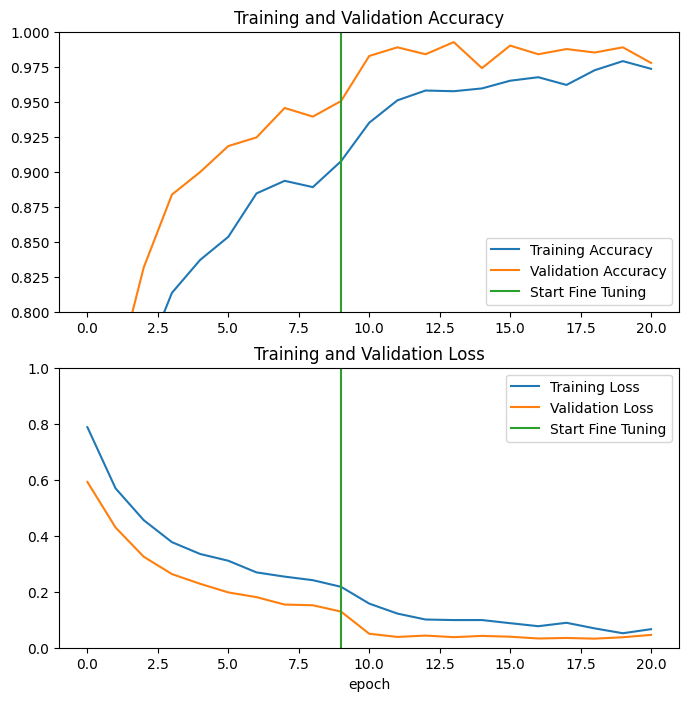

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 평가 및 예측

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 160ms/step - loss: 0.0313 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1]
Labels:
 [1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1]


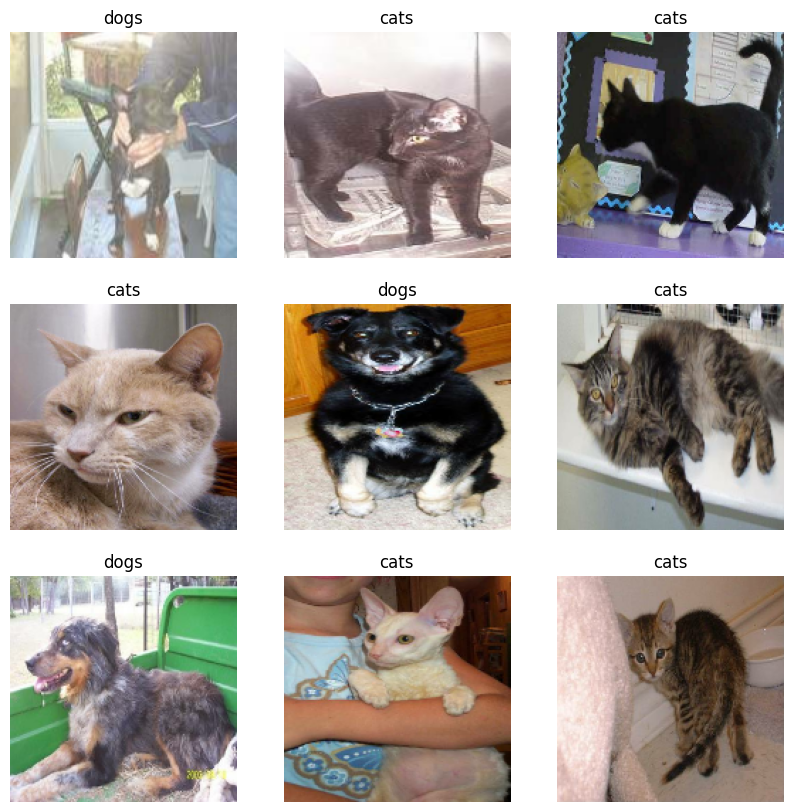

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# 오차행렬표

In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(label_batch, predictions)
conMatrix

array([[18,  0],
       [ 1, 13]], dtype=int64)

In [36]:
cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
             index=['true_%d' % i for i in range(cnt)],
             columns=['pred_%d' % i for i in range(cnt)] )

,pred_0,pred_1
true_0,18,0
true_1,1,13


Text(33.22222222222222, 0.5, 'true label')

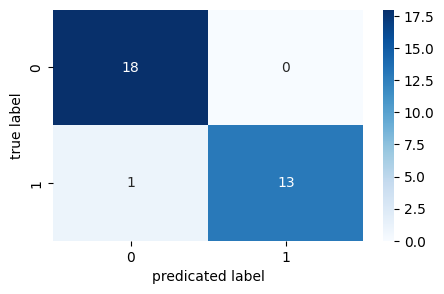

In [37]:
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

# 분류리포트

In [38]:
from sklearn.metrics import classification_report
print(classification_report(label_batch, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.93      0.96        14

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



# ROC 커브

6/6 [==============================] - 1s 137ms/step


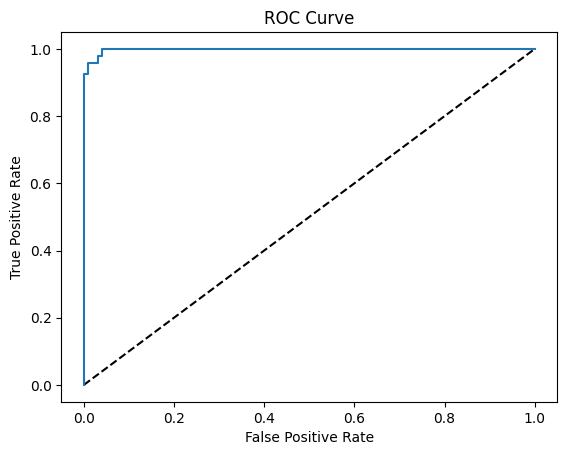

AUC:  0.9981545809813287


In [57]:
# ROC 커브곡선
from sklearn.metrics import roc_curve, roc_auc_score

test_images = []
test_labels = []

# Extract images and labels from the test_dataset
for image, label in test_dataset:
    test_images.append(image)
    test_labels.append(label)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Generate predictions
y_pred_prob = model.predict(test_images)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC score
print('AUC: ', roc_auc_score(test_labels, y_pred_prob))

# 파일 분류

In [88]:
from glob import glob
from PIL import Image
import numpy as np
import os
import shutil

base = 'c:/data/transfer-learning/'
fileList = glob(base+'/*.jpg')
for idx, file in enumerate(fileList):
    img = Image.open(file).resize((160,160)).convert('RGB')
    img = np.array(img)
    img = np.reshape(img,(1,160,160,3))
    yhat = model.predict(img)
    predictions = tf.nn.sigmoid(yhat)
    predictions = tf.where(yhat < 0.5, 0, 1)
    pred_name = class_names[predictions[0][0]]
    print(pred_name)
    
    if not os.path.exists(base+pred_name):
        os.mkdir(base+pred_name)
        
    newDir = base+pred_name
    newName = pred_name+str(idx+1)+'.jpg'
    os.rename(file, newName)
    shutil.move(base+newName, newDir)

1/1 [==============================] - 0s 25ms/step
cats
1/1 [==============================] - 0s 26ms/step
dogs
1/1 [==============================] - 0s 24ms/step
dogs
1/1 [==============================] - 0s 22ms/step
dogs
1/1 [==============================] - 0s 22ms/step
dogs
1/1 [==============================] - 0s 23ms/step
dogs
